In [1]:
import urllib
import urllib2
import json
import time
import hmac,hashlib
import quandl
import matplotlib.pyplot as plt
import numpy as np

def createTimeStamp(datestr, format="%Y-%m-%d %H:%M:%S"):
    return time.mktime(time.strptime(datestr, format))

class poloniex:
    def __init__(self, APIKey, Secret):
        self.APIKey = APIKey
        self.Secret = Secret

    def post_process(self, before):
        after = before

        # Add timestamps if there isnt one but is a datetime
        if('return' in after):
            if(isinstance(after['return'], list)):
                for x in xrange(0, len(after['return'])):
                    if(isinstance(after['return'][x], dict)):
                        if('datetime' in after['return'][x] and 'timestamp' not in after['return'][x]):
                            after['return'][x]['timestamp'] = float(createTimeStamp(after['return'][x]['datetime']))
                            
        return after

    def api_query(self, command, req={}):

        if(command == "returnTicker" or command == "return24Volume"):
            ret = urllib2.urlopen(urllib2.Request('https://poloniex.com/public?command=' + command))
            return json.loads(ret.read())
        elif(command == "returnOrderBook"):
            ret = urllib2.urlopen(urllib2.Request('http://poloniex.com/public?command=' + command + '&currencyPair=' + str(req['currencyPair'])))
            return json.loads(ret.read())
        elif(command == "returnMarketTradeHistory"):
            ret = urllib2.urlopen(urllib2.Request('http://poloniex.com/public?command=' + "returnTradeHistory" + '&type=buy' + '&currencyPair=' + str(req['currencyPair'] + '&amount=' + str(req['amount']))))
            return json.loads(ret.read())
        else:
            req['command'] = command
            req['nonce'] = int(time.time()*1000)
            post_data = urllib.urlencode(req)

            sign = hmac.new(self.Secret, post_data, hashlib.sha512).hexdigest()
            headers = {
                'Sign': sign,
                'Key': self.APIKey
            }

            ret = urllib2.urlopen(urllib2.Request('https://poloniex.com/tradingApi', post_data, headers))
            jsonRet = json.loads(ret.read())
            return self.post_process(jsonRet)


    def returnTicker(self):
        return self.api_query("returnTicker")

    def return24Volume(self):
        return self.api_query("return24Volume")

    def returnOrderBook (self, currencyPair):
        return self.api_query("returnOrderBook", {'currencyPair': currencyPair})

    def returnMarketTradeHistory (self, currencyPair, amount):
        return self.api_query("returnMarketTradeHistory", {'currencyPair': currencyPair, 'amount': amount})


    # Returns all of your balances.
    # Outputs: 
    # {"BTC":"0.59098578","LTC":"3.31117268", ... }
    def returnBalances(self):
        return self.api_query('returnBalances')

    # Returns your open orders for a given market, specified by the "currencyPair" POST parameter, e.g. "BTC_XCP"
    # Inputs:
    # currencyPair  The currency pair e.g. "BTC_XCP"
    # Outputs: 
    # orderNumber   The order number
    # type          sell or buy
    # rate          Price the order is selling or buying at
    # Amount        Quantity of order
    # total         Total value of order (price * quantity)
    def returnOpenOrders(self,currencyPair):
        return self.api_query('returnOpenOrders',{"currencyPair":currencyPair})


    # Returns your trade history for a given market, specified by the "currencyPair" POST parameter
    # Inputs:
    # currencyPair  The currency pair e.g. "BTC_XCP"
    # Outputs: 
    # date          Date in the form: "2014-02-19 03:44:59"
    # rate          Price the order is selling or buying at
    # amount        Quantity of order
    # total         Total value of order (price * quantity)
    # type          sell or buy
    def returnTradeHistory(self,currencyPair):
        return self.api_query('returnTradeHistory',{"currencyPair":currencyPair})

    # Places a buy order in a given market. Required POST parameters are "currencyPair", "rate", and "amount". If successful, the method will return the order number.
    # Inputs:
    # currencyPair  The curreny pair
    # rate          price the order is buying at
    # amount        Amount of coins to buy
    # Outputs: 
    # orderNumber   The order number
    def buy(self,currencyPair,rate,amount):
        return self.api_query('buy',{"currencyPair":currencyPair,"rate":rate,"amount":amount})

    # Places a sell order in a given market. Required POST parameters are "currencyPair", "rate", and "amount". If successful, the method will return the order number.
    # Inputs:
    # currencyPair  The curreny pair
    # rate          price the order is selling at
    # amount        Amount of coins to sell
    # Outputs: 
    # orderNumber   The order number
    def sell(self,currencyPair,rate,amount):
        return self.api_query('sell',{"currencyPair":currencyPair,"rate":rate,"amount":amount})

    # Cancels an order you have placed in a given market. Required POST parameters are "currencyPair" and "orderNumber".
    # Inputs:
    # currencyPair  The curreny pair
    # orderNumber   The order number to cancel
    # Outputs: 
    # succes        1 or 0
    def cancel(self,currencyPair,orderNumber):
        return self.api_query('cancelOrder',{"currencyPair":currencyPair,"orderNumber":orderNumber})

    # Immediately places a withdrawal for a given currency, with no email confirmation. In order to use this method, the withdrawal privilege must be enabled for your API key. Required POST parameters are "currency", "amount", and "address". Sample output: {"response":"Withdrew 2398 NXT."} 
    # Inputs:
    # currency      The currency to withdraw
    # amount        The amount of this coin to withdraw
    # address       The withdrawal address
    # Outputs: 
    # response      Text containing message about the withdrawal
    def withdraw(self, currency, amount, address):
        return self.api_query('withdraw',{"currency":currency, "amount":amount, "address":address})

In [10]:
API = 'foo'
secret = 'bar'

polo = poloniex(API, secret)

In [7]:
btc_data = quandl.get("BCHARTS/BITSTAMPUSD", start_date="2017-01-01")
print btc_data.keys()

Index([u'Open', u'High', u'Low', u'Close', u'Volume (BTC)',
       u'Volume (Currency)', u'Weighted Price'],
      dtype='object')


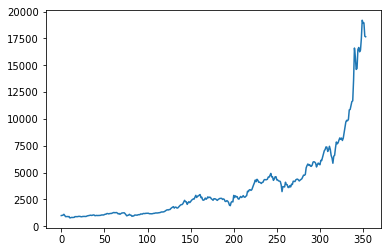

In [8]:
prices = [btc_data['Close'][i] for i in btc_data['Close'].keys()]
plt.plot(range(len(prices)), prices)
plt.show()

In [11]:
data = polo.returnMarketTradeHistory('BTC_LTC', '50000')

In [12]:
print data

[{u'tradeID': 13456736, u'amount': u'3.23210000', u'rate': u'0.01920000', u'date': u'2017-12-20 04:06:40', u'total': u'0.06205632', u'type': u'buy', u'globalTradeID': 297088213}, {u'tradeID': 13456735, u'amount': u'0.11427925', u'rate': u'0.01919218', u'date': u'2017-12-20 04:06:39', u'total': u'0.00219326', u'type': u'sell', u'globalTradeID': 297088185}, {u'tradeID': 13456734, u'amount': u'4.83209999', u'rate': u'0.01920000', u'date': u'2017-12-20 04:06:38', u'total': u'0.09277631', u'type': u'buy', u'globalTradeID': 297088174}, {u'tradeID': 13456733, u'amount': u'5.73237000', u'rate': u'0.01920000', u'date': u'2017-12-20 04:06:38', u'total': u'0.11006150', u'type': u'buy', u'globalTradeID': 297088166}, {u'tradeID': 13456732, u'amount': u'0.58056979', u'rate': u'0.01920000', u'date': u'2017-12-20 04:06:37', u'total': u'0.01114693', u'type': u'buy', u'globalTradeID': 297088128}, {u'tradeID': 13456731, u'amount': u'2.00000000', u'rate': u'0.01920000', u'date': u'2017-12-20 04:06:37', u'